# **=============== FUTURE SALES FORECAST ==============**

Pada project kali ini, saya akan mencoba untuk mempredikis penjualan atau total sales setiap produk dan toko pada setiap bulanya dengan menggunakan Time Series Analysis (ARIMA, SARIMA dan PROPHET). Seperti biasa, pada notebook ini akan dibagi kedalam beberapa bagian:

1. Konteks
2. Data Preprocessing
3. Modelling 
4. Kesimpulan

Pada notebook ini tidak akan secara mendalam membahas teorinya, namun saya akan menjelaskan kenapa langkah-langkah itu yang diambil. Mari kita mulai!

# **1. KONTEKS**

Project ini merupakan salah satu dari sebuah kompetisi di Kaggle. Datasetnya didapat dari penjualan produk pada perusahan di Rusia bernama 1C Company.

* Tujuan: memprediksi penjualan / sales bulan selanjutnya
* Data: 

    1. sales_train.csv (training set), data historis harian mulai dari Januari 2013 sampai Oktober 2015.
    2. test.csv (test set) kita harus memprediksi set ini yaitu penjualan toko dan produk pada bulan November 2015.
    3. sample_submission.csv - contoh hasil untuk dimasukkan ke dalam perlombaan
    4. items.csv - informasi tambahan terkait item / produk
    5. item_categories.csv - informasi tambahan terkait kategori item / produks 
    6. shops.csv- informasi tambahan terkait toko
    
 
* Detail Data:

    1. ID - sebuah id untuk  toko dan item
    2. shop_id - unique identifier untuk toko
    3. item_id - unique identifier item / produk
    4. item_category_id - unique identifier dari kategori itemnya
    5. item_cnt_day - jumlah item yang terjual harian, namun kita akan memprediksi ini dalam bulanan (November 2015)
    6. item_price - harga sebuah itemm
    7. date - tangal
    8. date_block_num - integer dari bulan pada kolom date untuk memudahkan, contoh: Januari 2013 itu 0, Februari 2013 itu 1, Oktober 2015 itu 33, dst
    9. item_name - nama item / produk
    10. shop_name - nama toko
    11. item_category_name - nama kategori
    

* Metriks Evaluasi: Root Mean Squared Error (RMSE)

* Manfaat: ada banyak sekali manfaat yang dapat diberikan dari prediksi ini, anatara lain,

    1. Marketing: membuat promo berdasarkan season yang ada pada waktu sebuah item paling laku
    2. Logistik: menyiapkan proses pengiriman agar tepat waktu
    3. Sales: meningkatkan pendapatan dari produk-produk yang paling laku, untuk lebih dimaksimalkan Harga Pokok Produknya
    4. Produksi: menyiapkan item sesuai dengan prediksi agar tidak terjadi kekurangan item saat high season atau dead stock saat low season

In [1]:
#Import packages /libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from math import sqrt

#Modeling
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from fbprophet import Prophet

#Evaluation
from sklearn.metrics import mean_squared_error
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
from fbprophet.plot import plot_cross_validation_metric

#Menghilangkan warning
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Melihat data yang ada di directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv


In [3]:
#Load semua data
items = pd.read_csv('../input/competitive-data-science-predict-future-sales/items.csv')
shops = pd.read_csv('../input/competitive-data-science-predict-future-sales/shops.csv')
sales = pd.read_csv('../input/competitive-data-science-predict-future-sales/sales_train.csv')
test = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv')
submission = pd.read_csv('../input/competitive-data-science-predict-future-sales/sample_submission.csv') #ini kita tidak pakai, karena hanya untuk input kompetisi
category = pd.read_csv('../input/competitive-data-science-predict-future-sales/item_categories.csv')

# **2. DATA PREPROCESSING**


Pada tahapan ini, kita akan mencoba untuk membersikan data sebelum masuk ke dalam model dan juga melakukan Exploratory Data Analysis untuk mendapatkan info-info yang menarik dan berguna untuk perusahaan.

## 2.1 Handling Variable

Melihat apakah input data dengan tipe data sudah sesuai atau belum, melakukan sedikit transformasi jika diperlukan atau aggregasi/grouping untuk memudahkan pada proses selanjutnya

In [4]:
#Mengabungkan semua data
data_1 = pd.merge(items, sales, on='item_id', how='inner')
data_2 = pd.merge(data_1, shops, on='shop_id', how='inner')
data = pd.merge(data_2, category, on='item_category_id', how='inner')

In [5]:
#Melihat sekilas data yang telah digabung
data.head()

,item_name,item_id,item_category_id,date,date_block_num,shop_id,item_price,item_cnt_day,shop_name,item_category_name
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,01.09.2014,20,54,58.0,1.0,"Химки ТЦ ""Мега""",Кино - DVD
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,24.08.2014,19,54,58.0,1.0,"Химки ТЦ ""Мега""",Кино - DVD
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,12.11.2014,22,54,58.0,1.0,"Химки ТЦ ""Мега""",Кино - DVD
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,05.07.2014,18,54,100.0,1.0,"Химки ТЦ ""Мега""",Кино - DVD
4,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,26.08.2014,19,54,58.0,1.0,"Химки ТЦ ""Мега""",Кино - DVD


In [6]:
#Melihat info pada data 
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   item_name           object 
 1   item_id             int64  
 2   item_category_id    int64  
 3   date                object 
 4   date_block_num      int64  
 5   shop_id             int64  
 6   item_price          float64
 7   item_cnt_day        float64
 8   shop_name           object 
 9   item_category_name  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 246.4+ MB


* Terdapat 10 kolom, 2935849 input, tipe data yang kita punya float64 ada 2, int64 ada 4, dan object ada 4.

In [7]:
#Merubah tipe data kolom item_cnt_day menjadi integer, karena inputnya adalah berapa barang yang terjual
data['item_cnt_day'] = data.item_cnt_day.astype('int')

In [8]:
#Merubah kolom date menjadi index dan merubah tipe datanya menjadi date
data['date'] = pd.to_datetime(data.date)
data =  data.sort_values('date').reset_index(drop=True)

In [9]:
#Melihat kembali dataset kita apakah kolom date sudah sesuai
data.head()

,item_name,item_id,item_category_id,date,date_block_num,shop_id,item_price,item_cnt_day,shop_name,item_category_name
0,"Тачки 2 (Essentials) [PSP, русская версия]",19929,21,2013-01-01,0,54,299.5,1,"Химки ТЦ ""Мега""",Игры - PSP
1,"Sims 3: Времена года (дополнение) [PC, русская...",6495,28,2013-01-01,0,27,699.0,2,"Москва ТЦ ""МЕГА Белая Дача II""",Игры PC - Дополнительные издания
2,Дарио Салас Соммер Практика повышения уровня ...,11288,43,2013-01-01,0,51,196.0,1,"Тюмень ТЦ ""Зеленый Берег""",Книги - Аудиокниги
3,Настольная игра Крестики-нолики и Четыре в ряд...,16135,65,2013-01-01,0,42,249.0,1,"СПб ТК ""Невский Центр""",Подарки - Настольные игры (компактные)
4,КЛАССИКА Ave Maria,12498,55,2013-01-01,0,54,199.0,1,"Химки ТЦ ""Мега""",Музыка - CD локального производства


In [10]:
#Melihat apakah ada input yang kosong pada data kita
data.isnull().sum() /len(data) *100

item_name             0.0
item_id               0.0
item_category_id      0.0
date                  0.0
date_block_num        0.0
shop_id               0.0
item_price            0.0
item_cnt_day          0.0
shop_name             0.0
item_category_name    0.0
dtype: float64

Ternyata dataset yang kita miliki tidak ada input yang kosong,sehingga kita tidak perlu melakukan pengisian

## 2.2 Feature Engineering

Melakuakn penambahan variabel pada data untuk memaksimalkan model ataupun untuk dapat mencari info-info yang menarik dari data

In [11]:
#Membuat kolom total_sales untuk melihat revenue / pendapatan perhari
data['total_sales'] = data['item_price'] * data['item_cnt_day']
data.head()

,item_name,item_id,item_category_id,date,date_block_num,shop_id,item_price,item_cnt_day,shop_name,item_category_name,total_sales
0,"Тачки 2 (Essentials) [PSP, русская версия]",19929,21,2013-01-01,0,54,299.5,1,"Химки ТЦ ""Мега""",Игры - PSP,299.5
1,"Sims 3: Времена года (дополнение) [PC, русская...",6495,28,2013-01-01,0,27,699.0,2,"Москва ТЦ ""МЕГА Белая Дача II""",Игры PC - Дополнительные издания,1398.0
2,Дарио Салас Соммер Практика повышения уровня ...,11288,43,2013-01-01,0,51,196.0,1,"Тюмень ТЦ ""Зеленый Берег""",Книги - Аудиокниги,196.0
3,Настольная игра Крестики-нолики и Четыре в ряд...,16135,65,2013-01-01,0,42,249.0,1,"СПб ТК ""Невский Центр""",Подарки - Настольные игры (компактные),249.0
4,КЛАССИКА Ave Maria,12498,55,2013-01-01,0,54,199.0,1,"Химки ТЦ ""Мега""",Музыка - CD локального производства,199.0


## 2.3 Handling Outliers

Pada tahapan ini kita mencoba mencari anomali atau outliers pada data yang kita miliki dan menilai apakah outliers ini memang kesalah, wajar atau menag acak

In [12]:
#Kita akan menggunakan Inter Quartile Range untuk menangani outliers
#Menentukan Limit
def limit(i):
    Q1,Q3 = np.percentile(data[i] , [25,75])
    IQR = Q3 - Q1
    
    #menentukan upper limit biasa dan upper limit ekstim
    lower_limit = Q1 - (IQR * 1.5)
    lower_limit_extreme = Q1 - (IQR * 3)
    upper_limit = Q3 + (IQR * 1.5)
    upper_limit_extreme = Q3 + (IQR * 3)
    print('Lower Limit:', lower_limit)
    print('Lower Limit Extreme:', lower_limit_extreme)
    print('Upper Limit:', upper_limit)
    print('Upper Limit Extreme:', upper_limit_extreme)

#Mengitung persen outliers dari data    
def percent_outliers(i):
    Q1,Q3 = np.percentile(data[i] , [25,75])
    IQR = Q3 - Q1
    
    #menentukan upper limit biasa dan upper limit ekstim
    lower_limit = Q1 - (IQR * 1.5)
    lower_limit_extreme = Q1 - (IQR * 3)
    upper_limit = Q3 + (IQR * 1.5)
    upper_limit_extreme = Q3 + (IQR * 3)
    #melihat persenan outliers terhadap total data
    print('Lower Limit: {} %'.format(data[(data[i] >= lower_limit)].shape[0]/ data.shape[0]*100))
    print('Lower Limit Extereme: {} %'.format(data[(data[i] >= lower_limit_extreme)].shape[0]/data.shape[0]*100))
    print('Upper Limit: {} %'.format(data[(data[i] >= upper_limit)].shape[0]/ data.shape[0]*100))
    print('Upper Limit Extereme: {} %'.format(data[(data[i] >= upper_limit_extreme)].shape[0]/data.shape[0]*100))

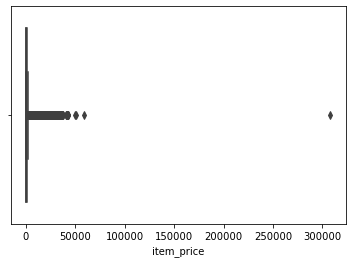

In [13]:
#Melihat outliers pada kolom item_price
sns.boxplot(x=data["item_price"])

In [14]:
#Melihat apakah ada harga item yang 0 atau minus. Karena jika ada ini merupakan sebuah kesalahan
data[data['item_price'] <= 0].count()

item_name             1
item_id               1
item_category_id      1
date                  1
date_block_num        1
shop_id               1
item_price            1
item_cnt_day          1
shop_name             1
item_category_name    1
total_sales           1
dtype: int64

Ternyata ada 1 item yang harganya 0 atau dibawah 0, maka kita akan hilangkan data tersebutkarena tidak mungkin ada harga jual 0 atau bahkan minus

In [15]:
#Menghilangkan input yang <= 0
data = data[data['item_price'] > 0]

In [16]:
#Melihat IQR dari kolom item_price
print(limit('item_price'))
print('-'*50)
print(percent_outliers('item_price'))

Lower Limit: -876.0
Lower Limit Extreme: -2001.0
Upper Limit: 2124.0
Upper Limit Extreme: 3249.0
None
--------------------------------------------------
Lower Limit: 100.0 %
Lower Limit Extereme: 100.0 %
Upper Limit: 8.821505745529059 %
Upper Limit Extereme: 2.687060093029339 %
None


Saya tidak mengaggap yang melebihi upper limit / upper limit extreme adalah outlier karena toko yang ada pada dataset ini memiliki variasi kategori item, sehingga mungkin saja salah satu item memiliki harga yang sangat tinggi atau sangat rendah, sehingga saja tidak menganggapnya outliers. Perlu diketahui juga bahwa dataset ini merupakan kumpulan dari beberapa toko dan kategori item, sehingga sangat memungkinkan terdapat harganya yang sangat beda.

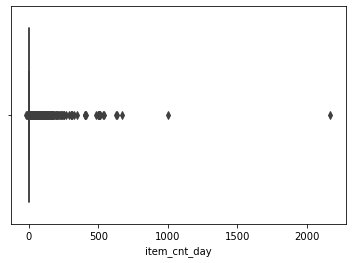

In [17]:
#Melihat outliers pada kolom item_cnt_day
sns.boxplot(x=data["item_cnt_day"])

In [18]:
#Melihat IQR pada kolom itm_cnt_day
print(limit('item_cnt_day'))
print('-'*50)
print(percent_outliers('item_cnt_day'))

Lower Limit: 1.0
Lower Limit Extreme: 1.0
Upper Limit: 1.0
Upper Limit Extreme: 1.0
None
--------------------------------------------------
Lower Limit: 99.74944206920794 %
Lower Limit Extereme: 99.74944206920794 %
Upper Limit: 99.74944206920794 %
Upper Limit Extereme: 99.74944206920794 %
None


Sebenarnya pada kolom item_cnt_day terdapat outlier yang inputnya 0 ataupun minus, ini akan kita cek di bawah dan menghilangkanya karena tidak mungkin ada penjualan yang 0(karena kita hanya akan mengambil yang laku) dan dibawah 0. Namun selain itu menurut saya bahwa mungkin saja dalam satu hari terdapat banyak sekali order dalam satu item karena mungkin ada hari-hari tertentu seperti natal, hari ibu dll yang biasanya banyak diskon yang mengakibatkan meningkatnya orderan, sehingga saya tidak menganggapnya sebagai outliers

In [19]:
#Mengecek apakah ada item yang dijual dalam jumlah 0 atau kurangdari 0, karena jika ada itu merupakan kesalahan
#Karena tida kmungkin item dijual dengan jumlah 0 (karena kita hanya mengambil yang laku) atau bahkan minus
data[data['item_cnt_day'] <= 0].count()

item_name             7356
item_id               7356
item_category_id      7356
date                  7356
date_block_num        7356
shop_id               7356
item_price            7356
item_cnt_day          7356
shop_name             7356
item_category_name    7356
total_sales           7356
dtype: int64

Seperti kita lihat di atas, ternyata ada 7356 input yang salah, sehingga kita akan hilangkan saja karena tidak mungkin kita gantikan secara statistik (mean/median)

In [20]:
#Menghilangkan input yang <= 0
data = data[data['item_cnt_day'] > 0]

## 2.4 Exploratory Data Analysis

Sebelum masuk kedalama model, kita akan mencoba untuk mencari info-info apa yang menarik dari data yang kita miliki sperti item apa yang paling laku, toko mana yang paling laku, item apa yang paling mahal, toko mana yang pendapanya paling banyak, item apa yang paling tidak laku, dll. Mari kita cari info-info menarik!

## **======================== 10 Item Terlaris ==========================**

Text(0, 0.5, 'Item Name')

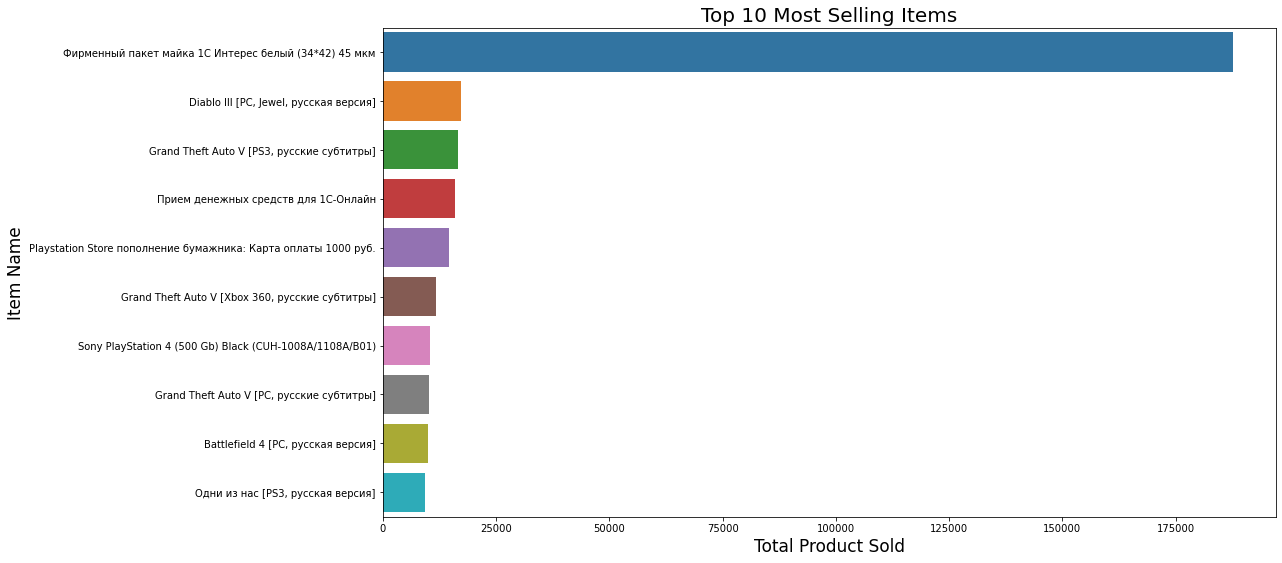

In [21]:
#Produk apa yang paling laris?
top_10_product_best_seller = data.groupby(['item_name'])['item_cnt_day'].sum().sort_values(ascending=False)[:10]

#Visualisasi 
plt.figure(figsize=(16,9))
sns.barplot(y=top_10_product_best_seller.index,x=top_10_product_best_seller.values)
plt.title('Top 10 Most Selling Items',fontsize=20)
plt.xlabel('Total Product Sold',fontsize=17)
plt.ylabel('Item Name',fontsize=17)

In [22]:
top_10_product_best_seller

item_name
Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм             187660
Diablo III [PC, Jewel, русская версия]                             17255
Grand Theft Auto V [PS3, русские субтитры]                         16676
Прием денежных средств для 1С-Онлайн                               15830
Playstation Store пополнение бумажника: Карта оплаты 1000 руб.     14522
Grand Theft Auto V [Xbox 360, русские субтитры]                    11733
Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1108A/B01)            10315
Grand Theft Auto V [PC, русские субтитры]                          10105
Battlefield 4 [PC, русская версия]                                 10041
Одни из нас [PS3, русская версия]                                   9255
Name: item_cnt_day, dtype: int64

Bisa kita lihat, bahwa yang paling banyak penjualnya dalam hal jumlah adalah "Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм" sebanyak 187666. Jika dilihat di google ini adalah kantong kresek, jadi wajar saja jika dia adalah paling bannyak penjualnya dan juga perlu diingat kembali bahwa ini adalah data dari dari Januari 2013 sampai OKtober 2015. jadi hampir 3 tahun. Kemudian jika dilihat di bawahnya kebanyakan adalah video game dan juga ada Playstation 4.

## **======================== 10 Item Paling Tidak Laku ==========================**

Text(0, 0.5, 'Item Name')

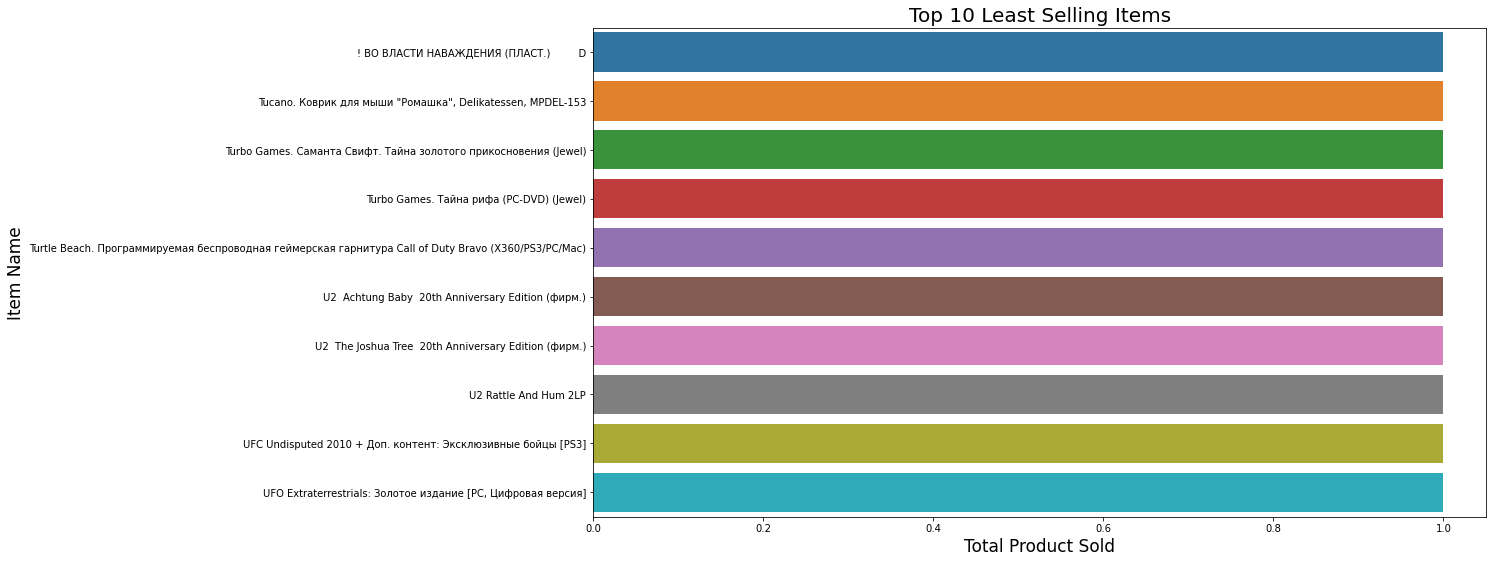

In [23]:
#Produk apa yang paling tidak laris?
top_10_product_least_seller = data.groupby(['item_name'])['item_cnt_day'].sum().sort_values(ascending=True)[:10]

#Visualisasi 
plt.figure(figsize=(16,9))
sns.barplot(y=top_10_product_least_seller.index,x=top_10_product_least_seller.values)
plt.title('Top 10 Least Selling Items',fontsize=20)
plt.xlabel('Total Product Sold',fontsize=17)
plt.ylabel('Item Name',fontsize=17)

Ini adalah 10 item yang paling tidak laku, penjualanya hanya 1 dalam waktu 2 tahun 10 bulan

## **======================== 10 Toko Terlaris ==========================**

Text(0, 0.5, 'Shop Name')

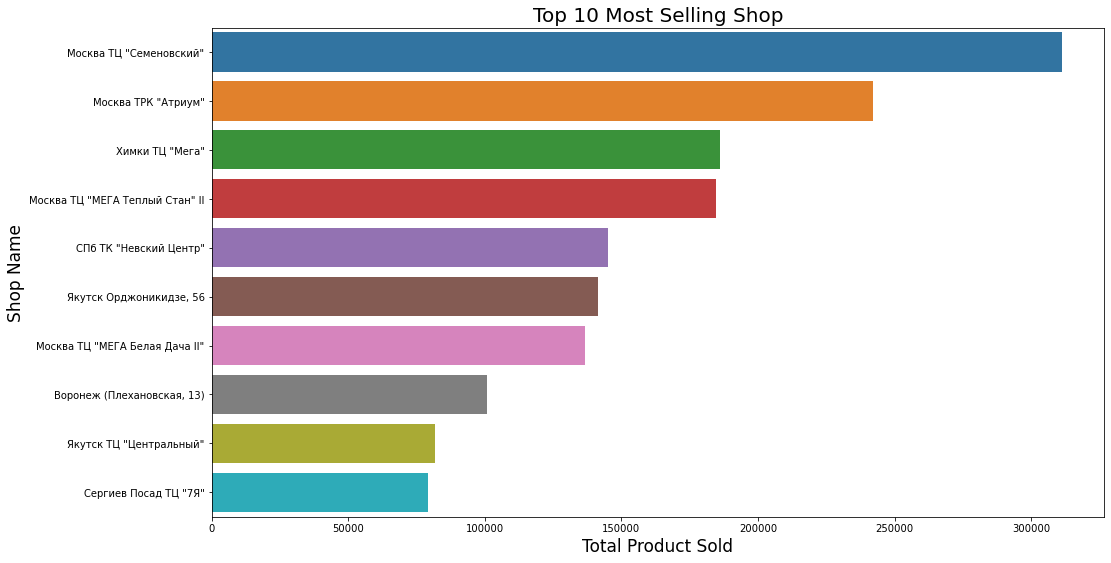

In [24]:
#Toko apa yang paling laris?
top_10_seller = data.groupby(['shop_name'])['item_cnt_day'].sum().sort_values(ascending=False)[:10]

#Visualisasi 
plt.figure(figsize=(16,9))
sns.barplot(y=top_10_seller.index,x=top_10_seller.values)
plt.title('Top 10 Most Selling Shop',fontsize=20)
plt.xlabel('Total Product Sold',fontsize=17)
plt.ylabel('Shop Name',fontsize=17)

In [25]:
top_10_seller

shop_name
Москва ТЦ "Семеновский"            311230
Москва ТРК "Атриум"                242237
Химки ТЦ "Мега"                    186149
Москва ТЦ "МЕГА Теплый Стан" II    184777
СПб ТК "Невский Центр"             145195
Якутск Орджоникидзе, 56            141424
Москва ТЦ "МЕГА Белая Дача II"     136815
Воронеж (Плехановская, 13)         100757
Якутск ТЦ "Центральный"             81908
Сергиев Посад ТЦ "7Я"               79092
Name: item_cnt_day, dtype: int64

Toko terbanyak dalma penjualan item adalah "Москва ТЦ "Семеновский" " dengan total penjualan 311230 item. Jika dilihat di google artinya adalah Semenovskiy Shopping & Entertainment Center, toko ini adalah Mall yang menjual segala macam kebutuhan, mulai dari fashion, gadget sampai makanan, sehingga wajar jika penjualanya no satu.

## **======================== 10 Toko Tidak Laris ==========================**

Text(0, 0.5, 'Shop Name')

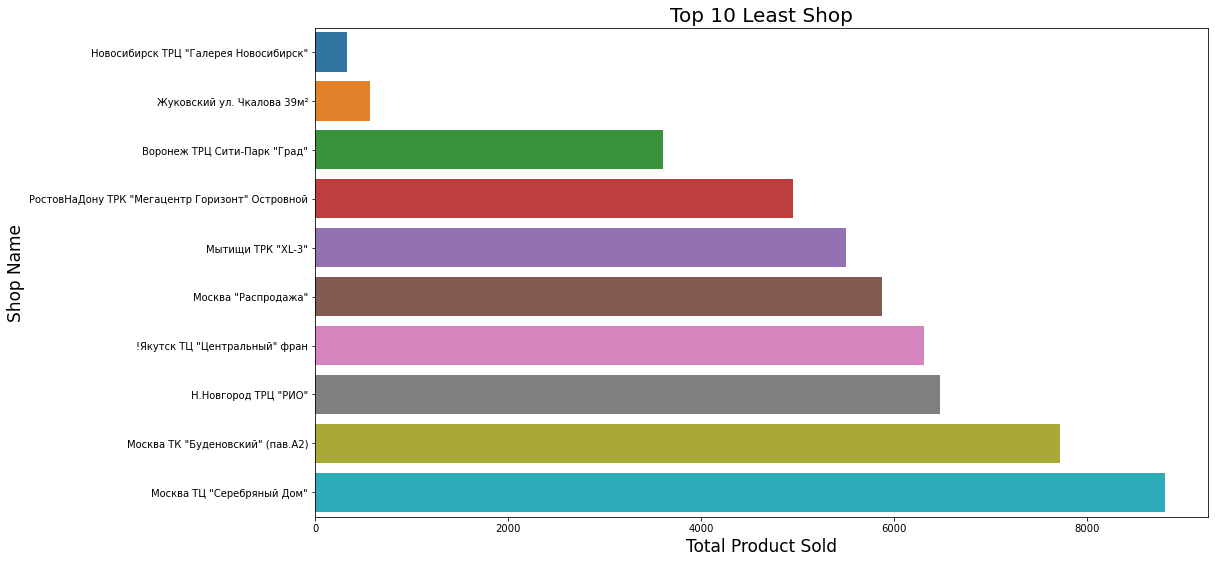

In [26]:
#Toko apa yang paling tidak laris?
top_10_least_seller = data.groupby(['shop_name'])['item_cnt_day'].sum().sort_values(ascending=True)[:10]

#Visualisasi 
plt.figure(figsize=(16,9))
sns.barplot(y=top_10_least_seller.index,x=top_10_least_seller.values)
plt.title('Top 10 Least Shop',fontsize=20)
plt.xlabel('Total Product Sold',fontsize=17)
plt.ylabel('Shop Name',fontsize=17)

In [27]:
top_10_least_seller

shop_name
Новосибирск ТРЦ "Галерея Новосибирск"               333
Жуковский ул. Чкалова 39м²                          572
Воронеж ТРЦ Сити-Парк "Град"                       3602
РостовНаДону ТРК "Мегацентр Горизонт" Островной    4956
Мытищи ТРК "XL-3"                                  5504
Москва "Распродажа"                                5873
!Якутск ТЦ "Центральный" фран                      6311
Н.Новгород ТРЦ "РИО"                               6476
Москва ТК "Буденовский" (пав.А2)                   7722
Москва ТЦ "Серебряный Дом"                         8814
Name: item_cnt_day, dtype: int64

Seperti kita lihat bahwa toko yang paling tidak laku adalah Новосибирск ТРЦ "Галерея Новосибирск" dengan 333 item terjual dalam waktu 2 tahun 10 bulan atau sekitar 9-10 item perbulan.

## **====================== 10 Toko Pendapatan Paling Tinggi ======================**

Text(0, 0.5, 'Shop Name')

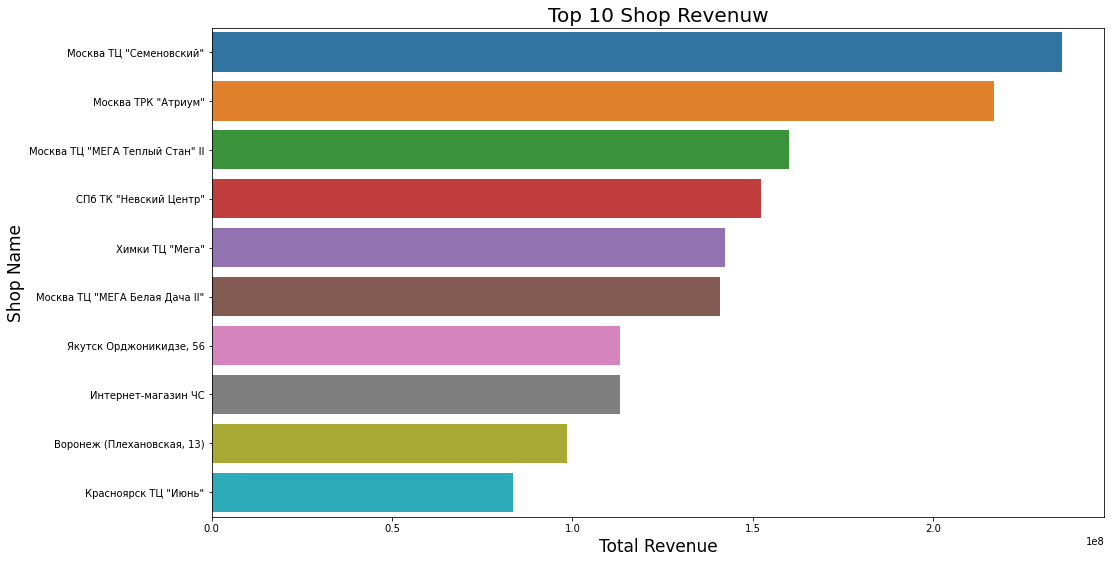

In [28]:
#Toko apa yang paling laris?
top_10_seller = data.groupby(['shop_name'])['total_sales'].sum().sort_values(ascending=False)[:10]

#Visualisasi
plt.figure(figsize=(16,9))
sns.barplot(y=top_10_seller.index,x=top_10_seller.values)
plt.title('Top 10 Shop Revenue',fontsize=20)
plt.xlabel('Total Revenue',fontsize=17)
plt.ylabel('Shop Name',fontsize=17)

In [29]:
top_10_seller

shop_name
Москва ТЦ "Семеновский"            2.356611e+08
Москва ТРК "Атриум"                2.169676e+08
Москва ТЦ "МЕГА Теплый Стан" II    1.601296e+08
СПб ТК "Невский Центр"             1.522791e+08
Химки ТЦ "Мега"                    1.424218e+08
Москва ТЦ "МЕГА Белая Дача II"     1.408849e+08
Якутск Орджоникидзе, 56            1.133351e+08
Интернет-магазин ЧС                1.131852e+08
Воронеж (Плехановская, 13)         9.847755e+07
Красноярск ТЦ "Июнь"               8.366872e+07
Name: total_sales, dtype: float64

Toko tertinggi pendapatanya adalah Москва ТЦ "Семеновский" dengan 2.356611e+08 Rubel atau setara 48.431.364.028,28 (48 Miliar). Jika kita lihat di google, memang jika diartikan adalah ini sebuah Mall yang berada di Rusia,jadi wajar saja jika keuntunganya sebesar itu, karena pendapatanya tidak hanya dari satu kategori item.

## **====================== 10 Toko Pendapatan Paling Rendah ======================**

Text(0, 0.5, 'Shop Name')

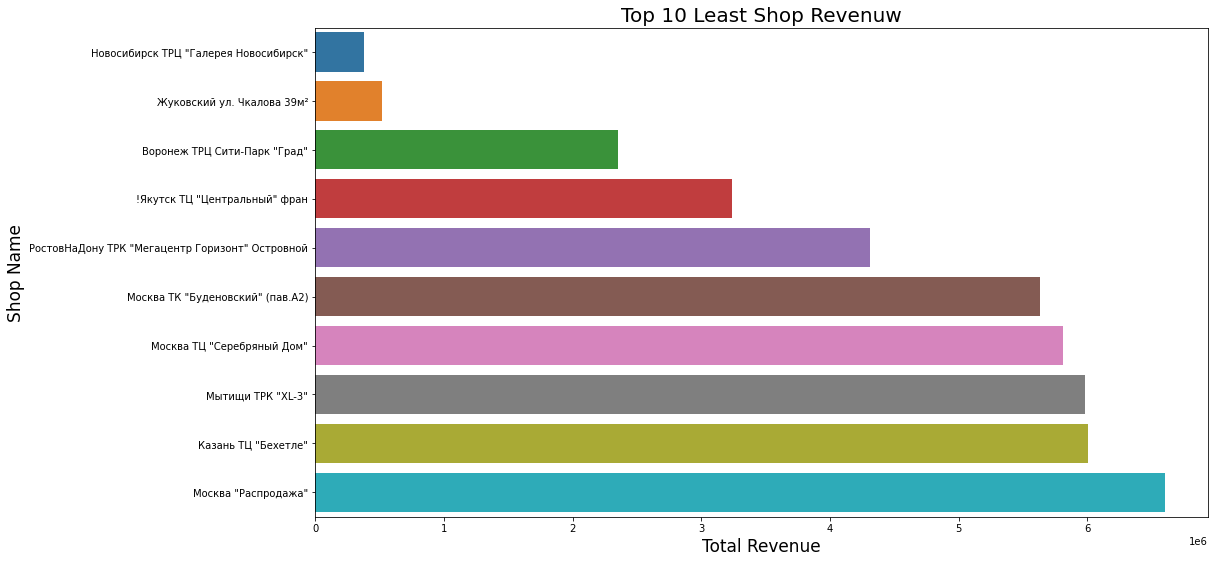

In [30]:
#Toko apa yang paling laris?
top_10_seller = data.groupby(['shop_name'])['total_sales'].sum().sort_values(ascending=True)[:10]

#Visualisasi
plt.figure(figsize=(16,9))
sns.barplot(y=top_10_seller.index,x=top_10_seller.values)
plt.title('Top 10 Least Shop Revenuw',fontsize=20)
plt.xlabel('Total Revenue',fontsize=17)
plt.ylabel('Shop Name',fontsize=17)

In [31]:
top_10_seller

shop_name
Новосибирск ТРЦ "Галерея Новосибирск"               379461.00
Жуковский ул. Чкалова 39м²                          521655.14
Воронеж ТРЦ Сити-Парк "Град"                       2353301.00
!Якутск ТЦ "Центральный" фран                      3238207.00
РостовНаДону ТРК "Мегацентр Горизонт" Островной    4308355.72
Москва ТК "Буденовский" (пав.А2)                   5630354.20
Москва ТЦ "Серебряный Дом"                         5807233.00
Мытищи ТРК "XL-3"                                  5982926.00
Казань ТЦ "Бехетле"                                6006173.18
Москва "Распродажа"                                6605923.00
Name: total_sales, dtype: float64

Toko yang memiliki pendapatan paling rendah adalah Новосибирск ТРЦ "Галерея Новосибирск" dengan 379461.00 Rubel sekitar 77.984.078,94 (77 Juta). Toko ini juga merupakan seperti Mall / marketplace.

## **======================== 10 Kategori Terlaris ==========================**

Text(0, 0.5, 'Category Name')

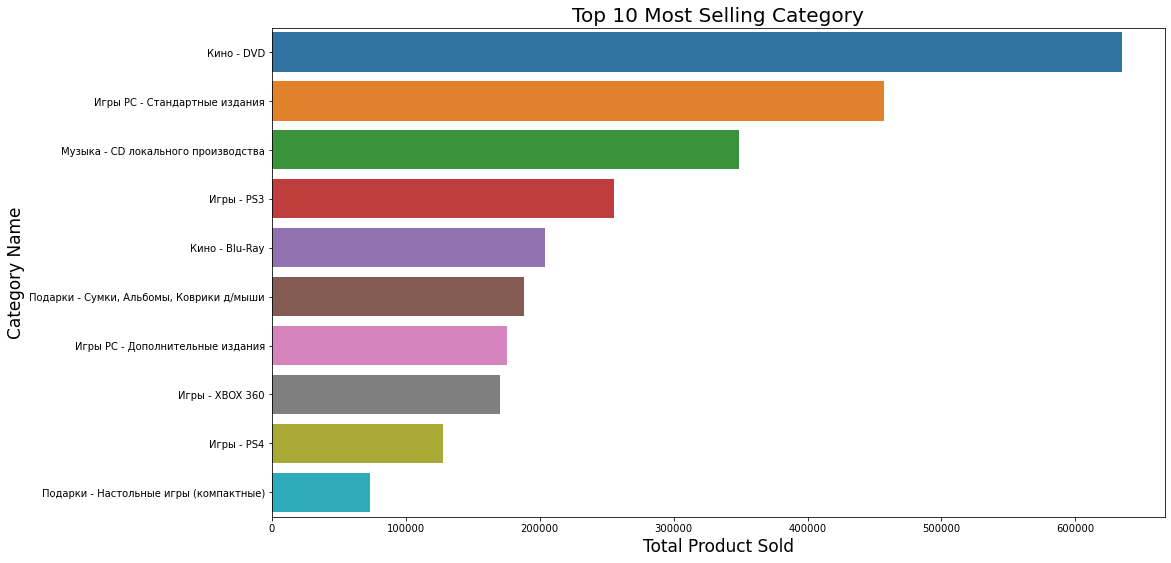

In [32]:
#kategori apa yang paling laris?
top_10_most_category = data.groupby(['item_category_name'])['item_cnt_day'].sum().sort_values(ascending=False)[:10]

#Visualisasi 10 item paling laris
plt.figure(figsize=(16,9))
sns.barplot(y=top_10_most_category.index,x=top_10_most_category.values)
plt.title('Top 10 Most Selling Category',fontsize=20)
plt.xlabel('Total Product Sold',fontsize=17)
plt.ylabel('Category Name',fontsize=17)

Seperti yang sudah diperkirakan,karena 10 produk terbanyak dalam penjualan adalah kebanyakan entertainment, maka tidak heran jika kategori produk yang paling laku juga enternainment seperti pada urutan paling atas adalah kategori DVD, kemudian adajuga PS 3, PS 4 dan XBOX 360.

## **======================== 10 Kategori Paling Tidak Laku ==========================**

Text(0, 0.5, 'Category Name')

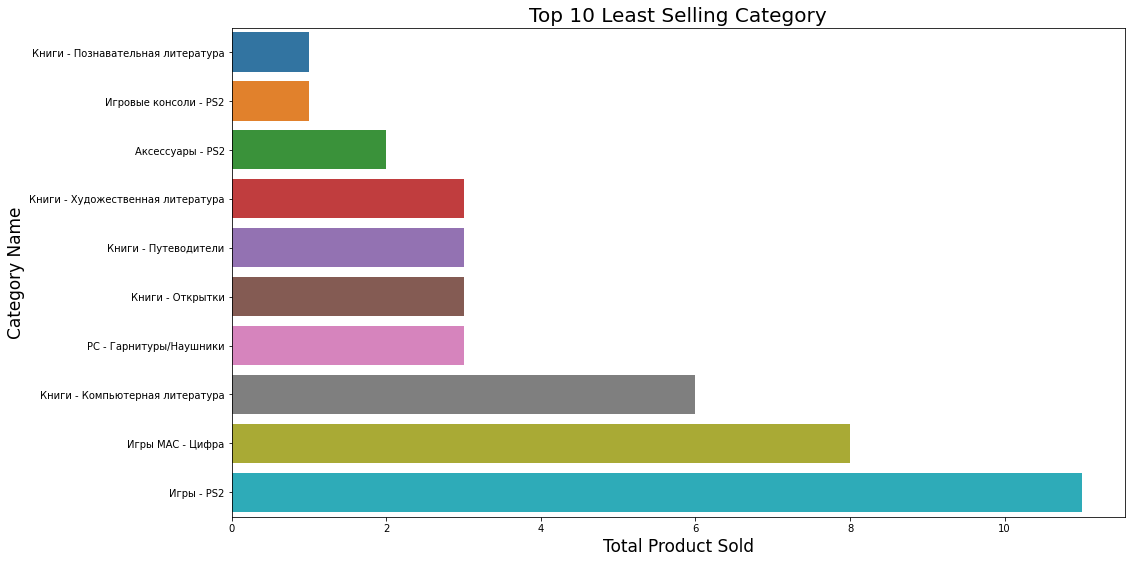

In [33]:
#kategori apa yang paling tidak laris?
top_10_least_category = data.groupby(['item_category_name'])['item_cnt_day'].sum().sort_values(ascending=True)[:10]

#Visualisasi 10 item paling laris
plt.figure(figsize=(16,9))
sns.barplot(y=top_10_least_category.index,x=top_10_least_category.values)
plt.title('Top 10 Least Selling Category',fontsize=20)
plt.xlabel('Total Product Sold',fontsize=17)
plt.ylabel('Category Name',fontsize=17)

kategori yang paling sedikit penjualanya adalah Книги - Познавательная литература jika diartikan maka akan muncul buku, dan kebanyakn dari 10 ini adalah buku semua, mungkin memang kategori buku kurang diminati.

# **3. MODELING**

Pada tahapan ini kita akan mencoba membuat model Time Series dengan menggunakan ARIMA, SARIMA dan PROPHET

In [34]:
#Merubah tipe data kolom date menjadi tipe date
data =  data.set_index('date')
data.head()

,item_name,item_id,item_category_id,date_block_num,shop_id,item_price,item_cnt_day,shop_name,item_category_name,total_sales
date,,,,,,,,,,
2013-01-01,"Тачки 2 (Essentials) [PSP, русская версия]",19929,21,0,54,299.5,1,"Химки ТЦ ""Мега""",Игры - PSP,299.5
2013-01-01,"Sims 3: Времена года (дополнение) [PC, русская...",6495,28,0,27,699.0,2,"Москва ТЦ ""МЕГА Белая Дача II""",Игры PC - Дополнительные издания,1398.0
2013-01-01,Дарио Салас Соммер Практика повышения уровня ...,11288,43,0,51,196.0,1,"Тюмень ТЦ ""Зеленый Берег""",Книги - Аудиокниги,196.0
2013-01-01,Настольная игра Крестики-нолики и Четыре в ряд...,16135,65,0,42,249.0,1,"СПб ТК ""Невский Центр""",Подарки - Настольные игры (компактные),249.0
2013-01-01,КЛАССИКА Ave Maria,12498,55,0,54,199.0,1,"Химки ТЦ ""Мега""",Музыка - CD локального производства,199.0


In [35]:
#Membuat data menjadi sebuah group dengan menghitung total sales setiap bulanya
train_arima = data.resample("M").sum() 
ts_sales = train_arima[["total_sales"]]
ts_sales.head()

,total_sales
date,
2013-01-31,8.168617e+07
2013-02-28,9.512712e+07
2013-03-31,1.009635e+08
2013-04-30,7.555049e+07
2013-05-31,8.047391e+07


In [36]:
#Menghilangkan data setelah oktober 2015 karena data setelah oktober tidak relevan, hanya sedikit data yang diambil
ts_sales = ts_sales[ts_sales.index <= pd.to_datetime('2015-10-31')]

## **3.1 Stationary**

Time series analysis membutuhkan data yang stationary, yaitu ketika mean, variance, dan covariance dianggap konstan sepanjang waktu agar mudah untuk dilakukan prediksinya, karena akan terlihat polanya. Untuk mengetahui apakah suatu data stationary atau tidak, disini saya menggunakan Dickey-Fuller test. Jika p-value di atas 0.05 maka datanya tidak stationary, namun jika di bawah 0.05 maka stationary.

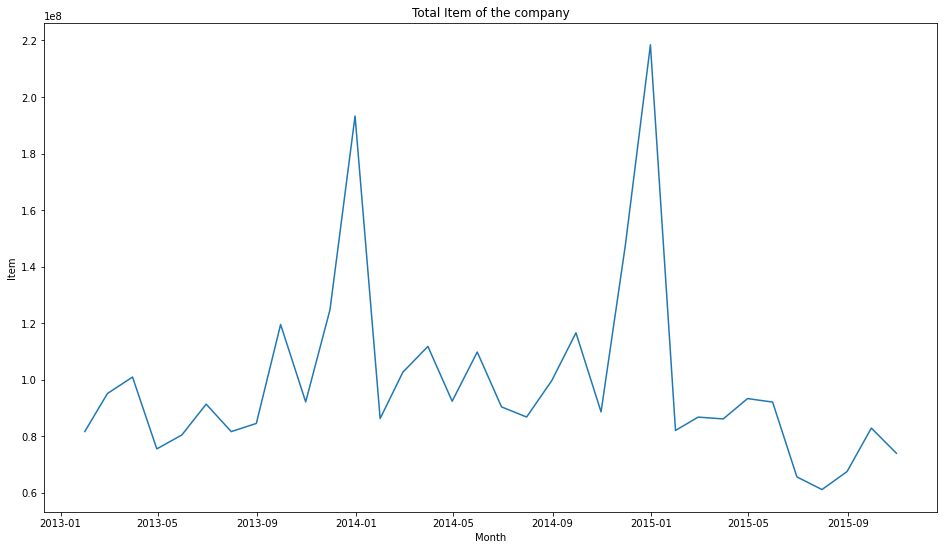

In [37]:
#Viasualisasi data
plt.figure(figsize=(16,9))
plt.title('Total Item of the company')
plt.xlabel('Month')
plt.ylabel('Item')
plt.plot(ts_sales['total_sales'])

Sebenaryya dari grafik di atas kita sudah bisa melihat bahwa data yang kita miliki kemungkinan stasionary,karena tidak ada perubahan dari mean, variance atau covariance secara kasat mata, namun kita perlu cek dengan Dickey-Fuller test.

In [38]:
#Melihat apakah data kita stationary atau tidak dengan Dickey-Fuller Test
#Membuat fungsi
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [39]:
#Cek Stationary
test_stationarity(ts_sales['total_sales'])

Results of Dickey-Fuller Test:
Test Statistic                 -4.278543
p-value                         0.000484
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


Seperti yang kita lihat di atas bahwa data memiliki p-value 0.000484 maka datanya stationary, sehingga kita tidak perlu membuatnya stationary dengan melakukan trnasformasi dengan differencing

## **3.2 Trend& Seasonality**

Untuk melihat apakah sebuah data memiliki trend yang cenderung naik atau turun dan juga melihat apakah ada siklus yang berulang pada waktu-waktu tertentu, contoh ketika setiap sebelum lebaran banyak orang yang belanja sehingga setiap waktu itu akan terjadi peningkatan penjualan. 

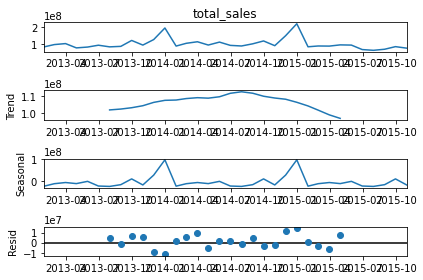

In [40]:
#Visualisasi Trend dan Seasonlaity
item_cnt_dec = sm.tsa.seasonal_decompose(ts_sales['total_sales'],freq=12).plot()

Darai kedua visualisasi di atas kita dapat melihat:
- data ini memiliki seasonality, terjadi peningkatan pada setiap akhir tahun serta penurunan di awal tahun
- terjadi peningkatan trend di awal sampaipertengahan data dan kemudian mengalami penuruan

## **3.3 Autocorrelation**

Autocorrelation digunakan untuk melihat apakah ada hubungan / korelasi antara nilai sekarang dengan nilai sebelumnya (lag / lagging / selisih). Setiap model regressi, mengasumsikan bahwa data tida ada korelasi. Autocorrelasi juga bisa digunakna untuk melihat seasonality atau trend yang tidak terlihat pada Lag 1, 2 dst.

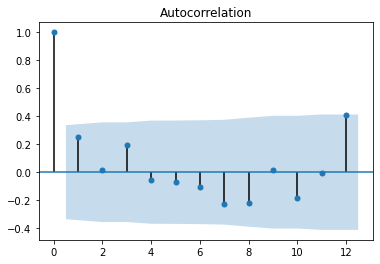

In [41]:
#Visualisasi autocorrelation plot pada data item_cnt_day
sales_acf = sm.graphics.tsa.plot_acf(ts_sales['total_sales'], lags=12)

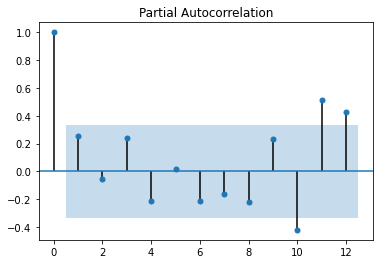

In [42]:
#Visualisasi autocorrelation plot pada data item_cnt_day
sales_acf = sm.graphics.tsa.plot_pacf(ts_sales['total_sales'], lags=12)

kita dapat melihat bahwa 95% data kita masuk kedalam confidence interval (area warna biru) sehingga bisa dikatakan data kita tidak memiliki autocorrelation. Kemudian dari data di atas bisa kita lihat bahwa nilai p dan q ada pada 1 atau 2

## **3.4 Modelling (SARIMA)**


Pada tahapan ini saya akan membuat prediksi dengan SARIMA (Seasonality Autoreggesive Integrated Moving Average) sebernarnya ini 4 metode yang dijadikan satu. Terdapat 4 parameter yaitu:
 - p: Seasonality (Autoregressive / AR)
 - d: Trend (Integrated / I)
 - q: Noice (Moving Average / MA)
 - s: Seasonality

In [43]:
#Membuat nilai p,d,q dengan rentang 0 and 3
p = d = q = range(0, 2)

#Membuat iterasi nilai p,dq
pdq = list(itertools.product(p, d, q))


#Membuat seasonal dengan 12 bulan (karena yang paling terlihat / smooth)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [44]:
#Melakukan pencarian nilai p,d,q dengan parameter AIC, semakin rendah semakin baik
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts_sales['total_sales'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=True,
                                            enforce_invertibility=True)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1353.7365764957174
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1374.618688140375
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:803.507402177148
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:797.8942328381554
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1280.4376731357374
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1291.450143691999
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:799.8146136745956
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:792.497079608711
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1335.9579394838129
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1335.0383730450387
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:800.916851389159
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:798.9249003210762
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1334.2444220198995
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1336.231996722139
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:800.0883698139866
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:792.880866116716
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1249.9412077578659
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1245.09905448215
ARIMA(0, 

Dari pencarian di atas, kita mendapatkan paramter p,d,q terbaik adalah ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:755.0370288027423 . Sekarang akan kita masukkan ke dalam model.

In [45]:
#Kita masukkan kedalma model
mod = sm.tsa.statespace.SARIMAX(ts_sales['total_sales'],
                                order=(0,1,0),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12       0.1267      0.146      0.869      0.385      -0.159       0.413
sigma2      2.218e+14   3.22e-17   6.88e+30      0.000    2.22e+14    2.22e+14


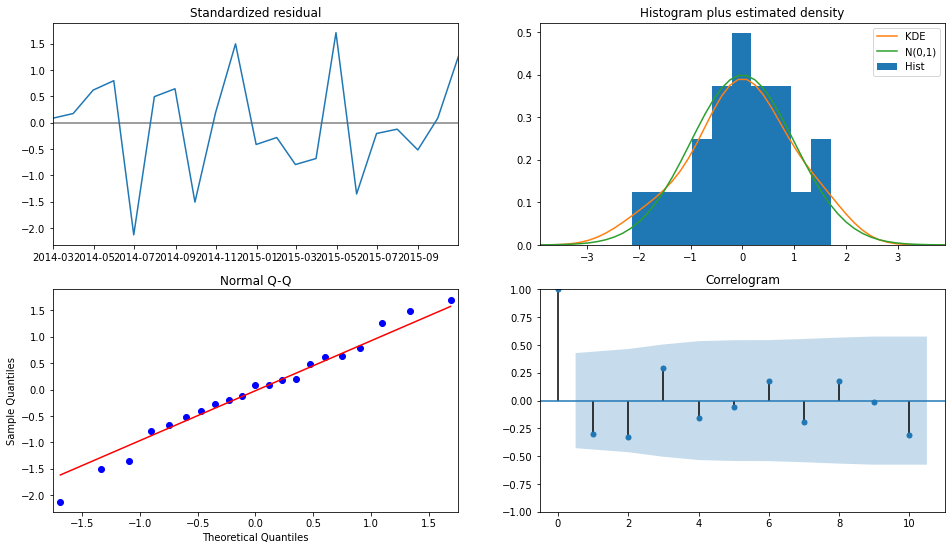

In [46]:
results.plot_diagnostics(figsize=(16, 9))
plt.show()

Dari graifk residual (Normal Q-Q), Corrleogram / ACF PCF, histogram kde, menunjukkan bahwa model yang kita buat sudah cukup optimal dengan melihat persebaranya yang mendekati normal

In [47]:
#Melakukan prediksi dari bulan Desember 2014
pred = results.get_prediction(start=pd.to_datetime('2014-12-31'), dynamic=False)
pred_ci = pred.conf_int()

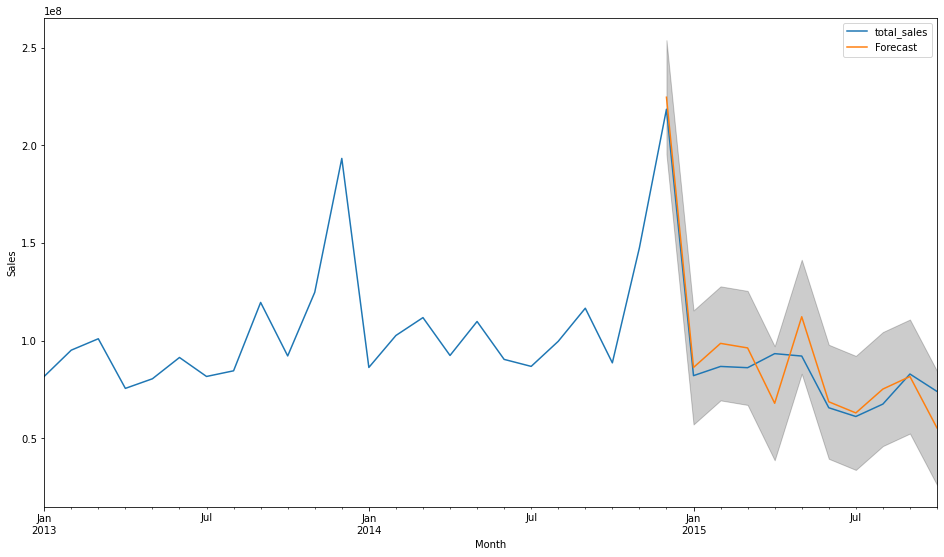

Root Mean Squared Error:  12688719.018302761


In [48]:
#Visualisasi prediksi
ax = ts_sales['2013-01-31':].plot(label = "observed", figsize=(16, 9))
pred.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Month')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

train_sarima_forecasted = pred.predicted_mean
train_sarima_truth = ts_sales['2014-12-31':]

#Menghiung RMSE
rmse_sarima = sqrt(mean_squared_error(train_sarima_truth, train_sarima_forecasted))
print("Root Mean Squared Error: ", rmse_sarima)

Pada model SARIMA kita mendapatkan RMSE sebesar 12688719.01 yang artinya kemungkinan eror data kita dengan predikisinya seberar tersebut. Saya rasa ini sudah lumayan optimal,karena perbandingan dari besaran total sales reratanya mencapai 98 juta atau kemungkinan model kita salah prediksi dari nilai sebesar 12.8% dari nilai.

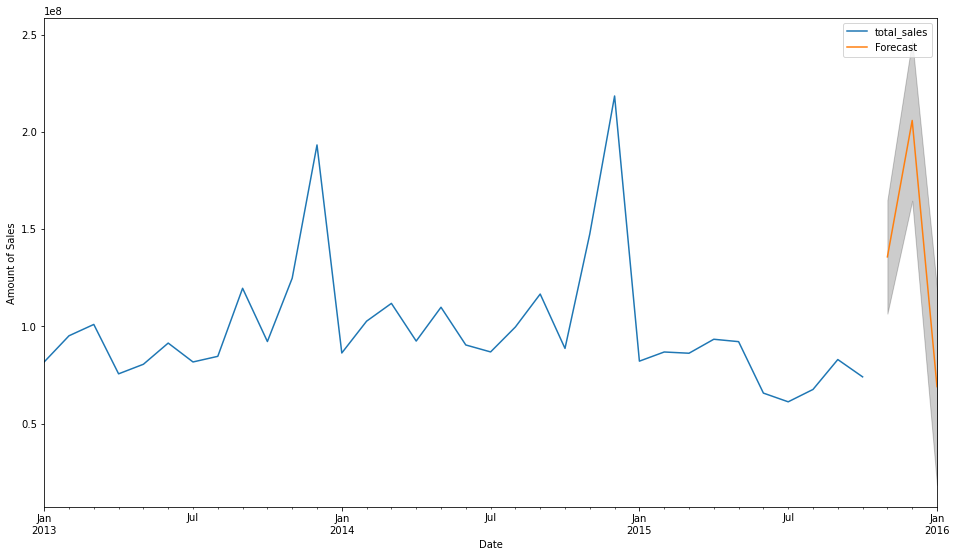

In [49]:
#Prediksi 3 total sales 3 bulan kedepan
pred_uc = results.get_forecast(steps=3)
pred_ci = pred_uc.conf_int()
ax = ts_sales['2013-01-31':].plot(label='observed', figsize=(16, 9))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Amount of Sales')
plt.legend()
plt.show()

Seperti yang kita lihat bahwa prediksinya memang sesuia dugaan, yaitu pada akhir tahun memang akan terjadi peningkatan sales dan pada wal tahun akan terjadi penurunan sales.

## **3.5 Modelling (PROPHET)**

Prophet adalah library yang dikeluarkan oleh facebook untuk melakukan Time Series Analysis, perbedaanya dengan yang lain adalah lebih ke praktisan dan ke akuratanya. Krena kita sudah mengecek tentang Stationary, Seasonality, Autocorrelation dll pada model sebelumnya, maka sekarang langsung melakukan model.

In [50]:
#Reset index dulu untuk membuat date menjadi kolom
ts_sales = ts_sales.reset_index()
#Pertama kita harus merubah dates menjadi ds dan total_sales menjadi y
ts_sales.rename(columns={'date':'ds','total_sales':'y'},inplace=True)

In [51]:
#Membuat prediksi dengan Prophet
m_p = Prophet()
m_p.fit(ts_sales)
future = m_p.make_future_dataframe(periods = 3, freq = 'M')
prediction = m_p.predict(future)
prediction.tail(3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
34,2015-11-30,8.396599e+07,1.206272e+08,1.301984e+08,8.389189e+07,8.403186e+07,4.155306e+07,4.155306e+07,4.155306e+07,4.155306e+07,4.155306e+07,4.155306e+07,0.0,0.0,0.0,1.255190e+08
35,2015-12-31,8.177012e+07,1.941880e+08,2.035357e+08,8.151237e+07,8.200422e+07,1.170985e+08,1.170985e+08,1.170985e+08,1.170985e+08,1.170985e+08,1.170985e+08,0.0,0.0,0.0,1.988687e+08
36,2016-01-31,7.957426e+07,4.040150e+07,4.958521e+07,7.908632e+07,8.004469e+07,-3.492019e+07,-3.492019e+07,-3.492019e+07,-3.492019e+07,-3.492019e+07,-3.492019e+07,0.0,0.0,0.0,4.465406e+07


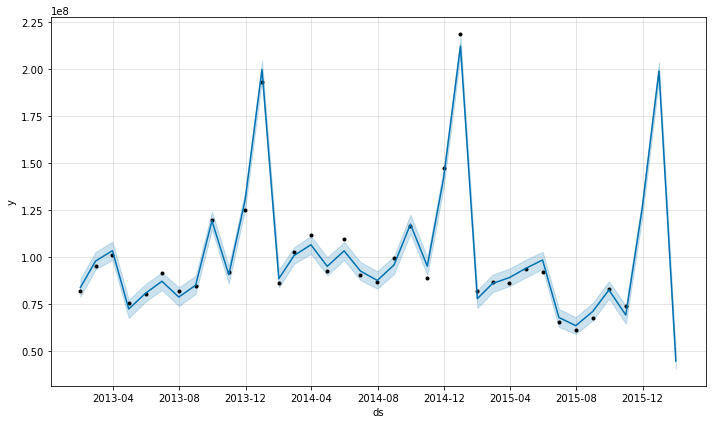

In [52]:
#Visualisai Prediksi
m_p.plot(prediction)
plt.show()

Model dengan menggunakan Prophet bisa kita lihat cukup baik, titik yang berwarna hitam adalah nilai aktualnya dan garis yang berwarna biru adalah nilai prediksinya, bisa dilihat bahwa model kita sudah cukup baik dalam memprediksi. Seperti pada prediksi dengan menggunakan SARIMA, prediksi yang dihasilkan sama-sama menunjukkan bahwa terjadi peningkatan pada bulan November sampai Januari dan kemudian mengalami penurunan setelah bulan Januari.

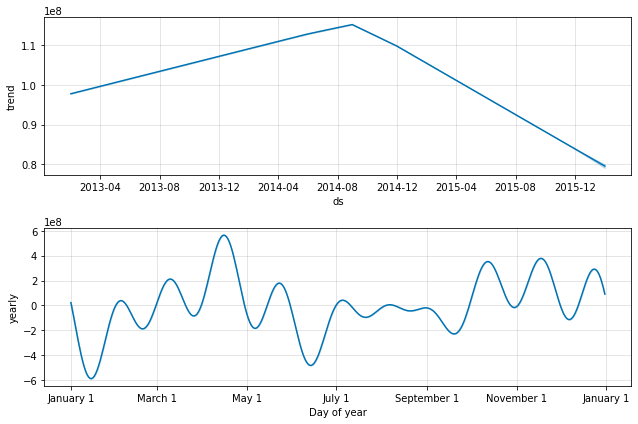

In [53]:
#Visualisasi [Trends,Weekly]
m_p.plot_components(prediction)
plt.show()

Seperti yang kita lihat di atas, trend menunjukkan penurunan, hal ini sesuai dengan trend yang memang dari awal dataset ini perlihatkan seperti pada model SARIMA sebelumnya

## Crossvalidation

Melihat eror dari nilai yang diprediksi dengan nilai aslinya dengan meggunakan parameter:
- initial:berapa banyak data yang digunakan untuk training
- period : berapa banyak yang digunakan untuk prediksi
- horizon : berapa rentang waktu yang digunakan untuk prediksi
- Secara defalut, initial traing itu 3x dari horizon dan periode itu setengahnya horizon

In [54]:
#Melakukan Crossvalidation dengan training data 720 (2 tahun), prediksi 120 (4 bulan) dan interval waktunya 240 (8 bulan)
cv = cross_validation(m_p,initial='720 days', period='120 days', horizon = '240 days')

In [55]:
#Melihat hasil cv
cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-03-31,1.128919e+08,1.116222e+08,1.142395e+08,8.614853e+07,2015-03-05
1,2015-04-30,1.014614e+08,1.000476e+08,1.027486e+08,9.333959e+07,2015-03-05
2,2015-05-31,1.322850e+08,1.309246e+08,1.336428e+08,9.210676e+07,2015-03-05
3,2015-06-30,8.304504e+07,8.153200e+07,8.442874e+07,6.564269e+07,2015-03-05
4,2015-07-31,8.620922e+07,8.485203e+07,8.770733e+07,6.116204e+07,2015-03-05


In [56]:
#Melihat performance metrics
df_pm= performance_metrics(cv)
df_pm.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,26 days,7.152059e+14,2.674333e+07,2.674333e+07,0.310433,0.310433,0.0
1,56 days,6.596427e+13,8.121839e+06,8.121839e+06,0.087014,0.087014,0.0
2,87 days,1.614294e+15,4.017828e+07,4.017828e+07,0.436214,0.436214,0.0
3,117 days,3.028420e+14,1.740236e+07,1.740236e+07,0.265107,0.265107,0.0
4,148 days,6.273615e+14,2.504719e+07,2.504719e+07,0.409522,0.409522,0.0


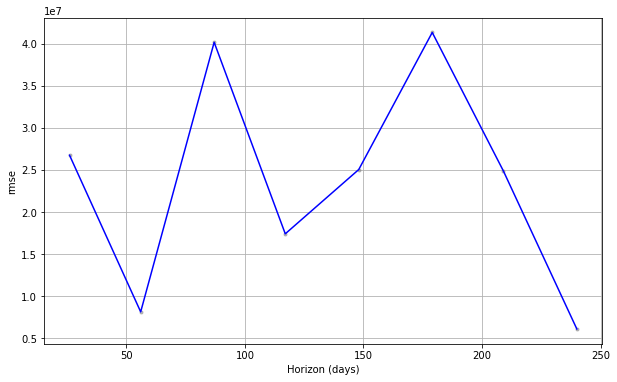

In [57]:
#Visualiasi RMSE
plot_cross_validation_metric(cv, metric='rmse')
plt.show()

Jika kita rerata rmse dari model prophet maka didapatkan 23.726.608.27, sehingga model  ini lebih buruk dari SARIMA sebelumnya,hal ini mungkin bisa dilakukan tunning, dengan menambahkan holiday, dll karena prophet sangat bekerja baik jika data yang dimasukkan sangat detail.

# **4. KESIMPULAN**


1. Model terbaik pada project kali ini adalah dengan menggunakan SARIMA
2. RMSE yang didapat 12.688.719,01 atau 12.8% dari rata-rata data
3. Perlu adanya tunning untuk model Prophet dengan menambahkan variabel lain seperti holiday
4. Prediksi total sales 3 bulan kedepan seperti di bawah:

In [58]:
pred_ci

,lower total_sales,upper total_sales
2015-11-30,1.065300e+08,1.649149e+08
2015-12-31,1.645982e+08,2.471668e+08
2016-01-31,1.838983e+07,1.195153e+08
